In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
from insightface.app import FaceAnalysis

c:\Users\nike1\projects\photo_clustering\.venv\Lib\site-packages\albumentations\check_version.py:147: UserWarning: Error fetching version info [SSL: WRONG_VERSION_NUMBER] wrong version number (_ssl.c:2658)
  data = fetch_version_info()


In [2]:
print("CUDA доступна:", torch.cuda.is_available())

CUDA доступна: True


In [3]:
app = FaceAnalysis(name = 'buffalo_l',
    providers=['CUDAExecutionProvider', 'CPUExecutionProvider']
)
app.prepare(ctx_id=0, det_size=(1280, 1280))

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {'device_id': '0', 'has_user_compute_stream': '0', 'cudnn_conv1d_pad_to_nc1d': '0', 'user_compute_stream': '0', 'gpu_external_alloc': '0', 'gpu_mem_limit': '18446744073709551615', 'enable_cuda_graph': '0', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'do_copy_in_default_stream': '1', 'cudnn_conv_use_max_workspace': '1', 'tunable_op_enable': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'prefer_nhwc': '0', 'use_ep_level_unified_stream': '0', 'use_tf32': '1', 'sdpa_kernel': '0', 'fuse_conv_bias': '0'}, 'CPUExecutionProvider': {}}
find model: C:\Users\nike1/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'

In [13]:
from qdrant_client import QdrantClient
from qdrant_client.models import VectorParams, Distance

client = QdrantClient("http://192.168.0.12:6333")

COLLECTION_NAME = "faces_with_thumbs"

client.recreate_collection(
    collection_name=COLLECTION_NAME,
    vectors_config=VectorParams(
        size=512,                 
        distance=Distance.COSINE  
    )
)

print("Коллекция создана")

Коллекция создана


C:\Users\nike1\AppData\Local\Temp\ipykernel_13760\2036157032.py:8: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


In [14]:
import os
import cv2
from tqdm import tqdm

IMAGE_FOLDER = "photos"
THUMBS_FOLDER = "thumbs"

os.makedirs(THUMBS_FOLDER, exist_ok=True)

def clamp(val, lo, hi):
    return max(lo, min(hi, val))

def expand_bbox_xyxy(bbox_xyxy, scale, img_w, img_h):
    """
    bbox_xyxy: [x1, y1, x2, y2] (float/int)
    scale: 2.0 => в 2 раза больше по ширине/высоте относительно центра
    """
    x1, y1, x2, y2 = bbox_xyxy
    x1, y1, x2, y2 = float(x1), float(y1), float(x2), float(y2)

    # иногда модели могут вернуть bbox "наоборот"
    if x2 < x1:
        x1, x2 = x2, x1
    if y2 < y1:
        y1, y2 = y2, y1

    w = x2 - x1
    h = y2 - y1
    cx = x1 + w / 2.0
    cy = y1 + h / 2.0

    new_w = w * scale
    new_h = h * scale

    nx1 = int(round(cx - new_w / 2.0))
    ny1 = int(round(cy - new_h / 2.0))
    nx2 = int(round(cx + new_w / 2.0))
    ny2 = int(round(cy + new_h / 2.0))

    nx1 = clamp(nx1, 0, img_w - 1)
    ny1 = clamp(ny1, 0, img_h - 1)
    nx2 = clamp(nx2, 0, img_w)
    ny2 = clamp(ny2, 0, img_h)

    # защита от пустого кропа
    if nx2 <= nx1:
        nx2 = clamp(nx1 + 1, 1, img_w)
    if ny2 <= ny1:
        ny2 = clamp(ny1 + 1, 1, img_h)

    return [nx1, ny1, nx2, ny2]

def rel_web_path(path_like):
    # приводит путь к виду "/thumbs/xxx.jpg" (слеши как в URL)
    return "/" + path_like.replace("\\", "/").lstrip("/")

face_points = []
point_id = 0

# если в "photos" есть подпапки, сохраним структуру в thumbs (опционально)
def thumb_output_path(src_path, face_idx):
    # src_path: photos/2024/DSC_0130.jpg -> thumbs/2024/DSC_0130_0.jpg
    rel = os.path.relpath(src_path, IMAGE_FOLDER)
    rel_dir = os.path.dirname(rel)
    base, _ = os.path.splitext(os.path.basename(rel))
    out_dir = os.path.join(THUMBS_FOLDER, rel_dir)
    os.makedirs(out_dir, exist_ok=True)
    return os.path.join(out_dir, f"{base}_{face_idx}.jpg")

for root, dirs, files in os.walk(IMAGE_FOLDER):
    for file in tqdm(files):
        if not file.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        full_path = os.path.join(root, file)
        img = cv2.imread(full_path)
        if img is None:
            continue

        h, w = img.shape[:2]
        faces = app.get(img)

        for face_idx, face in enumerate(faces):
            embedding = face.embedding.tolist()

            # bbox обычно [x1, y1, x2, y2]
            bbox = face.bbox.tolist()

            # расширяем bbox в 2 раза
            thumb_bbox = expand_bbox_xyxy(bbox, scale=3.0, img_w=w, img_h=h)
            x1, y1, x2, y2 = thumb_bbox
            crop = img[y1:y2, x1:x2]

            # сохраняем превью
            out_thumb_path = thumb_output_path(full_path, face_idx)
            ok = cv2.imwrite(out_thumb_path, crop)
            if not ok:
                continue

            # делаем "веб-пути" как в примере пользователя
            # full: "/photos/DSC_0130.jpg" (с учётом подпапок)
            rel_full = os.path.relpath(full_path, ".")
            rel_thumb = os.path.relpath(out_thumb_path, ".")

            face_points.append({
                "id": point_id,
                "vector": embedding,
                "payload": {
                    "thumb": rel_web_path(rel_thumb),  # "/thumbs/....jpg"
                    "full": rel_web_path(rel_full),    # "/photos/....jpg"
                    "parent_path": full_path,          # реальный путь (удобно для отладки)
                    "bbox": bbox,                      # bbox лица (как вернула модель)
                    "thumb_bbox": thumb_bbox           # bbox кропа в исходном изображении
                }
            })

            point_id += 1

print("Всего найдено лиц:", len(face_points))

100%|██████████| 324/324 [01:51<00:00,  2.90it/s]

Всего найдено лиц: 761


In [15]:
from qdrant_client.models import PointStruct

points = [
    PointStruct(
        id=p["id"],
        vector=p["vector"],
        payload=p["payload"]
    )
    for p in face_points
]

client.upsert(
    collection_name=COLLECTION_NAME,
    points=points
)

print("Лица успешно загружены в Qdrant")

Лица успешно загружены в Qdrant



Кластер 0, всего фото: 761


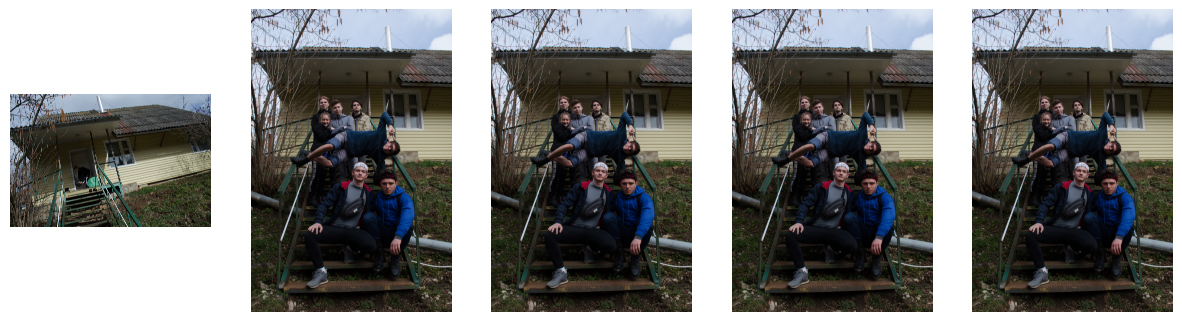

In [5]:
import matplotlib.pyplot as plt
from collections import defaultdict
from qdrant_client import QdrantClient

client = QdrantClient("http://192.168.0.12:6333")
COLLECTION_NAME = "faces"

# scroll возвращает tuple
points, _ = client.scroll(
    collection_name=COLLECTION_NAME,
    with_vectors=False,
    limit=10000
)

clusters = defaultdict(list)

for p in points:
    cluster_id = p.payload.get("cluster_id", 0)
    clusters[cluster_id].append(p.payload["photo_path"])

# Вывод примеров
for cluster_id, photos in clusters.items():
    print(f"\nКластер {cluster_id}, всего фото: {len(photos)}")

    sample_photos = photos[:5]

    fig, axes = plt.subplots(1, len(sample_photos), figsize=(15,5))
    if len(sample_photos) == 1:
        axes = [axes]

    for ax, photo_path in zip(axes, sample_photos):
        img = plt.imread(photo_path)
        ax.imshow(img)
        ax.axis("off")

    plt.show()